In [1]:
import scanpy as sc
import scanpy.external as sce
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.9.19


In [4]:
#import matplotlib as mpl
plt.rc('font',family='Arial')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
warnings.filterwarnings( "ignore")

In [6]:
sc.logging.print_versions()

-----
anndata     0.10.5
scanpy      1.10.1
-----
CoreFoundation              NA
Foundation                  NA
PIL                         10.3.0
PyObjCTools                 NA
anyio                       NA
appnope                     0.1.4
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
brotli                      1.1.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastcluster                 1.2.6
fastjsonschema              NA
fqdn                        NA
h5py       


# Load data

In [7]:
adata = sc.read_h5ad('AML/data/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad')

In [8]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000236601',
       ...
       'ENSG00000275249', 'ENSG00000274792', 'ENSG00000274175',
       'ENSG00000275869', 'ENSG00000273554', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=37733)

In [9]:
adata.var_names_make_unique(join='_')

In [10]:
adata.obs['unique_id'] = adata.obs['barcode'].astype(str)+'_' + adata.obs['library'].astype(str)

In [11]:
adata.obs['unique_id']

1          GGTAGTAC_ACTCCGTCTC_AACAGGCT_BB2.1
2          TGTTCAGG_ACTCCGTCTC_AACAGGCT_BB2.1
3          ATGGCAGT_ACTCGCATCC_AACAGGCT_BB2.1
4          CGCATGAG_ACTGCGTCGT_AACAGGCT_BB2.1
6          CGTTAGTC_ACTGCTGTCC_AACAGGCT_BB2.1
                         ...                 
111562    ATCGACTG_TCAAGCGTGG_TGCATCAC_BB3.10
111565    TCTGAGGA_TCGGACTCAC_TGCATCAC_BB3.10
111567    AGCTAGGT_TGCAGCACAC_TGCATCAC_BB3.10
111568    CCTACGTG_TGCAGCACAC_TGCATCAC_BB3.10
111569    TAGCGATC_TGGCAACCAC_TGCATCAC_BB3.10
Name: unique_id, Length: 86447, dtype: object

# Normalize counts

In [13]:
#save not normalized counts as adata.raw, can normalize any time if needed
#adata.raw = adata.copy()

In [14]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)


In [15]:
adata.X.sum(axis = 1)


matrix([[10000.002],
        [10000.001],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.001],
        [10000.001]], dtype=float32)

# Save one copy of the data to master spring directory in a spring-compatible format

In [16]:
adata.obs['total_counts']

1          1137.0
2          2659.0
3          2314.0
4         31448.0
6          3235.0
           ...   
111562      750.0
111565      834.0
111567      560.0
111568     1528.0
111569      845.0
Name: total_counts, Length: 86447, dtype: float32

In [17]:
adata.obs['n_counts'] = adata.obs['total_counts']

In [18]:
path1 = os.getcwd()
path1

'/Users/justina/Documents/mokslai/LAB/amniotic_fluid/data and SPRING'

In [19]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000236601',
       ...
       'ENSG00000275249', 'ENSG00000274792', 'ENSG00000274175',
       'ENSG00000275869', 'ENSG00000273554', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=37733)

In [20]:

project_dir = path1+'/AML_full'


In [21]:
# save (once), may be slow
#srz.save_counts_for_spring(adata,project_dir)
project_dir

'/Users/justina/Documents/mokslai/LAB/amniotic_fluid/data and SPRING/AML_full'

# choose parameters for SPRING (Weinreb et al., 2018)

In [22]:
print ([i for i in adata.obs['cell_type_refined'].unique()])

['Early Immature Neutrophils', 'CD14 Monocytes', 'Immature Neutrophils', 'Aged Neutrophils', 'Mature Neutrophils', 'CD16 Monocytes', 'Tem/Temra cytotoxic T cells', 'Precursors of Neutrophils', 'Naive B cells', 'AML cells 8', 'Tem/Effector helper T cells', 'Memory B cells', 'Tcm/Naive helper T cells', 'Basophils', 'Regulatory T cells', 'NK cells', 'Erythrocytes', 'MAIT T cells', 'Platelets', 'AML cells 9', 'AML cells 4', 'Tcm/Naive cytotoxic T cells', 'AML cells 10', 'Dendritic cells', 'AML Monocytes 2', 'CD14CD16 Monocytes', 'AML cells 1', 'Plasma cells', 'AML cells 5', 'AML cells 2', 'AML cells 7', 'AML cells 3', 'AML cells 6', 'AML Monocytes 1']


In [23]:
cell_mask = adata.obs['cell_type_refined'].isin(['Precursors of Neutrophils'])
                                                 

In [24]:
cell_mask.sum()

2167

In [25]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object



cdata = adata[cell_mask].copy() # not all cells in this case

# save a copy of data before taking the log:
#cdata.uns['X_lin_cptt'] = cdata.X.copy() # for X linear counts-per-10-thousand
cdata.layers['X_lin_cptt'] = cdata.X.copy()

In [26]:
cdata.layers['X_lin_cptt'].sum(axis=1)

matrix([[10000.   ],
        [ 9999.997],
        [ 9999.998],
        ...,
        [ 9999.999],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [27]:
# log transform
sc.pp.log1p(cdata)
cdata.layers['X_log'] = cdata.X.copy()

In [28]:


# chose a name for the spring subplot
plot_name = 'AML_prec_only'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.layers['X_lin_cptt']

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([   0,    1,    2, ..., 2164, 2165, 2166]),
 'num_pc': 20,
 'plot_name': 'AML_prec_only'}

In [29]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 10

pdict['min_counts'] = 10
pdict['min_cells'] = 20
pdict['embedding'] = 'umap'
#pdict['base_ix'] = np.arange(E.shape[0])[adata.obs[cell_mask]['seq_date'].isin(['21_04_14', '20_11_17', 'old']).values]

print(len(pdict['base_ix']))

2167


### Gene selection criteria

In [30]:
# avoid genes starting with
toavoid = ['MT-','RPS','RPL','MRPL','MRPS']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

MT-
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


RPS
['RPS6KA1', 'RPS8', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPSA', 'RPS3A', 'RPS23', 'RPS14', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPS12', 'RPS6KA2', 'RPS6KA2-IT1', 'RPS6KA2-AS1', 'RPS20', 'RPS6', 'RPS24', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS26', 'RPS29', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPS17', 'RPS2', 'RPS15A', 'RPS6KB1', 'RPS15', 'RPS28', 'RPSAP58', 'RPS16', 'RPS19', 'RPS11', 'RPS9', 'RPS5', 'RPS21', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPS4Y1', 'RPS4Y2']


RPL
['RPL22', 'RPL11', 'RPL5', 'RPL31', 'RPL37A-DT', 'RPL37A', 'RPL32', 'RPL15', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-DT', 'RPL34', 'RPL37', 'RPL26L1-AS1', 'RPL26L1', 'RPL10A', 'RPL7L1', 'RPL7', 'RPL30', 'RPL30-AS1', 'RPL8', 'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPL3

In [31]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E[pdict['base_ix'],:],
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

205 genes excluded based on name
5193 genes passing abundance filter


In [32]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

32745
32654
5079 surviving genes so far


In [33]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
# the function automatically removes genes with zero expression, but better
# to get rid of these in advance at this point.

isexpr = np.array(E[pdict['base_ix'],:].sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[pdict['base_ix'],:][:,isexpr])

# print the number of genes with v scores above mode
# these but not more can be considered variable

maxvar = pdict['v_score_dict']['var_gene_mask'][combmask[isexpr]].sum()
print("Out of the surviving genes, %d have a v-score above mode"%maxvar)

25445 genes with non-zero expression
Out of the surviving genes, 3605 have a v-score above mode


In [34]:
# out of the surviving genes, select a fix number of most variable ones
# this is one of the possible strategies
nrvar = 2000
pdict['nr_var_genes'] = nrvar

# place v score and gene names into a temporary pd.Series for convenience:
v = pd.Series(pdict['v_score_dict']['v_scores'],index=cdata.var_names[isexpr])


# get the names of the top most variable genes:
pdict['genes_used'] = v[combmask[isexpr]].sort_values(ascending=False)[:nrvar].index

# plot a v score vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

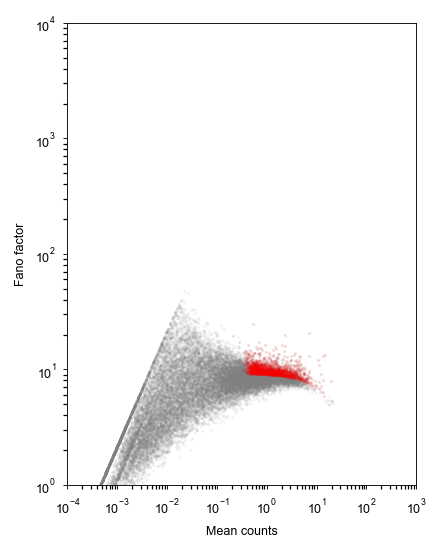

In [35]:
# check scatter
s = 2
plt.figure(figsize=(3,4))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');
#plt.savefig(project_dir, dpi = 600)

### Prepare data for PCA

In [36]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(2167, 37733)
(2167, 2000)


In [37]:



# zscore
sc.pp.scale(cdata)

# keep a copy of the data:
cdata.layers['X_log_z'] = cdata.X.copy()

In [38]:
# Z score was calculated already
Z = cdata.layers['X_log_z']

In [39]:
# find the number of non-random PCs
d = srz.find_num_pc(Z[pdict["base_ix"],:],sparse=False)

calculating the first 200 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 18 	 0.02 min.
2 	 20 	 0.04 min.
3 	 20 	 0.06 min.
4 	 19 	 0.07 min.
5 	 20 	 0.09 min.
6 	 19 	 0.10 min.
7 	 19 	 0.12 min.
8 	 19 	 0.14 min.
9 	 20 	 0.15 min.
10 	 20 	 0.17 min.


In [40]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_


print(d['num_pc'])


18


In [41]:
# apply dimensionality reduction on Z (get principle components)
# note, that eigenvalues can be calculated for base_ix only
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(2167, 18)


In [42]:
#store these values in adata as if scanpy pca was ran

In [43]:
cdata.obsm['X_pca'] = P
cdata.varm['PCs'] = pdict['eigenvectors'][:pdict['num_pc'],:].T
cdata.uns['pca'] = {}

cdata.uns['pca']['variance'] = pdict['eigenvalues']

In [45]:
##looking where is the batch effect

In [46]:
#just checking if the batch correction worked properly, will adjust neighbor number or umap parameters later
sc.pp.neighbors(cdata, 20, use_rep = 'X_pca')
sc.tl.umap(cdata, min_dist = 0.6, random_state = 42)

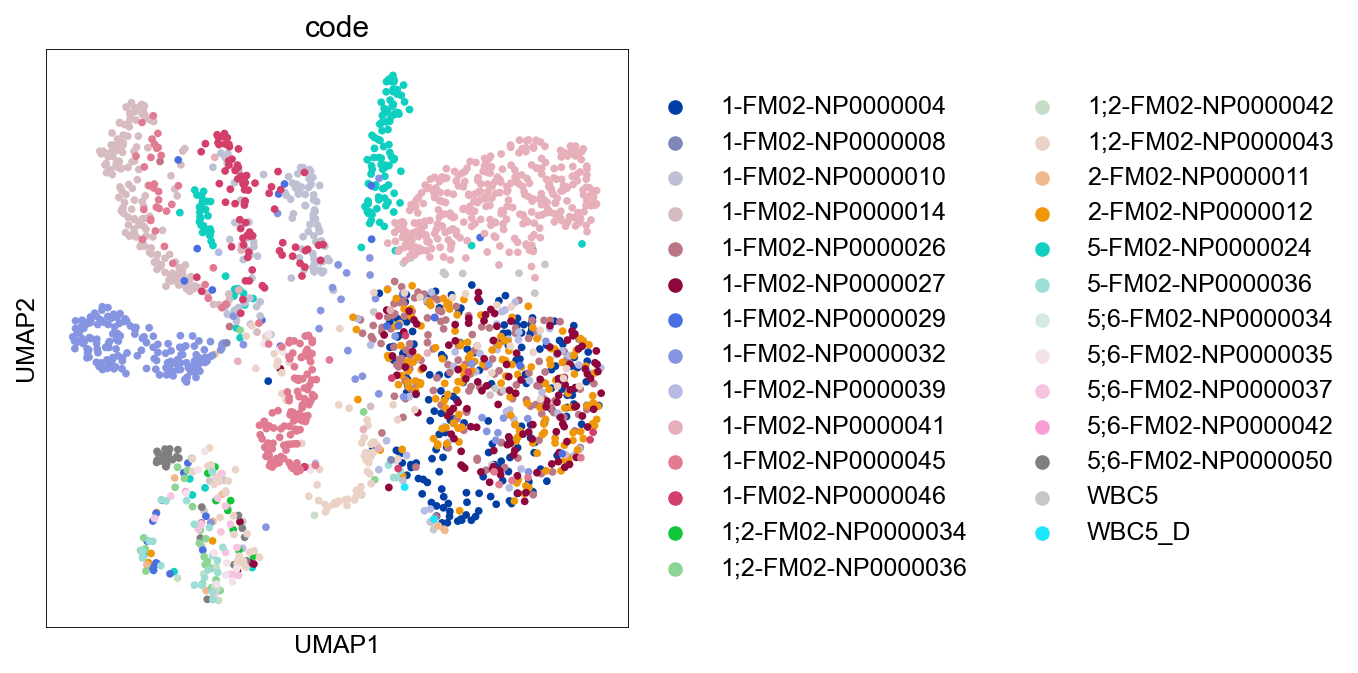

In [48]:
sc.pl.umap(cdata, color=['code'])

In [49]:
#load CADPON information

filename = 'AML/data/cadpon_obs_1939x3_250116_12h27.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [51]:
obs['unique_id'] = obs['barcode'].astype(str)+'_' + obs['library'].astype(str)

In [52]:
CAPS_id = [i for i in list(cdata.obs['unique_id']) if i in list(obs['unique_id'])]

In [53]:
len(CAPS_id)

1072

In [54]:
CAPS_mask = cdata.obs['unique_id'].isin(CAPS_id)

In [55]:
cdata.obs['subset_neut_mask'] = CAPS_mask

In [56]:
mask_caps = obs['cell_type_CADPON'].isin(['CAPs'])

In [57]:
CAPS_only_id = [i for i in list(cdata.obs['unique_id']) if i in list(obs['unique_id'][mask_caps])]

In [58]:
len(CAPS_only_id)

432

In [59]:
CAPS_only_mask = cdata.obs['unique_id'].isin(CAPS_only_id)

In [60]:
cdata.obs['caps_only'] = CAPS_only_mask

## Choose the "optimal" UMAP parameters

In [112]:
neighbor_list = [ 10, 15, 20, 30]
dist_list = [ 0.3, 0.6]
##

In [113]:
#!mkdir p 'outputs/umaps'

10 neighbors


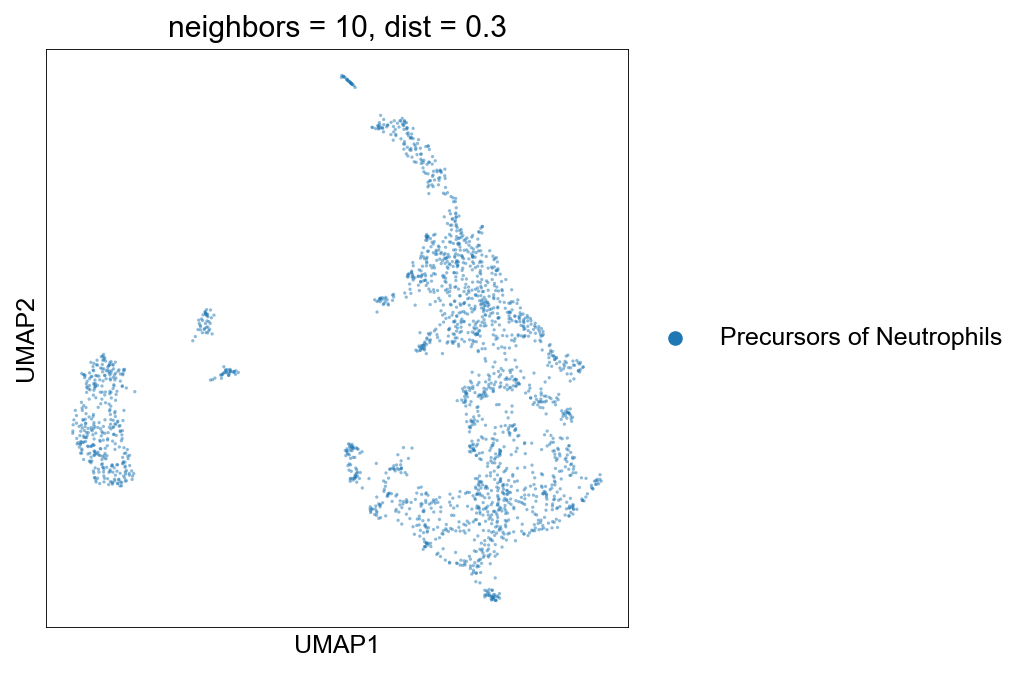

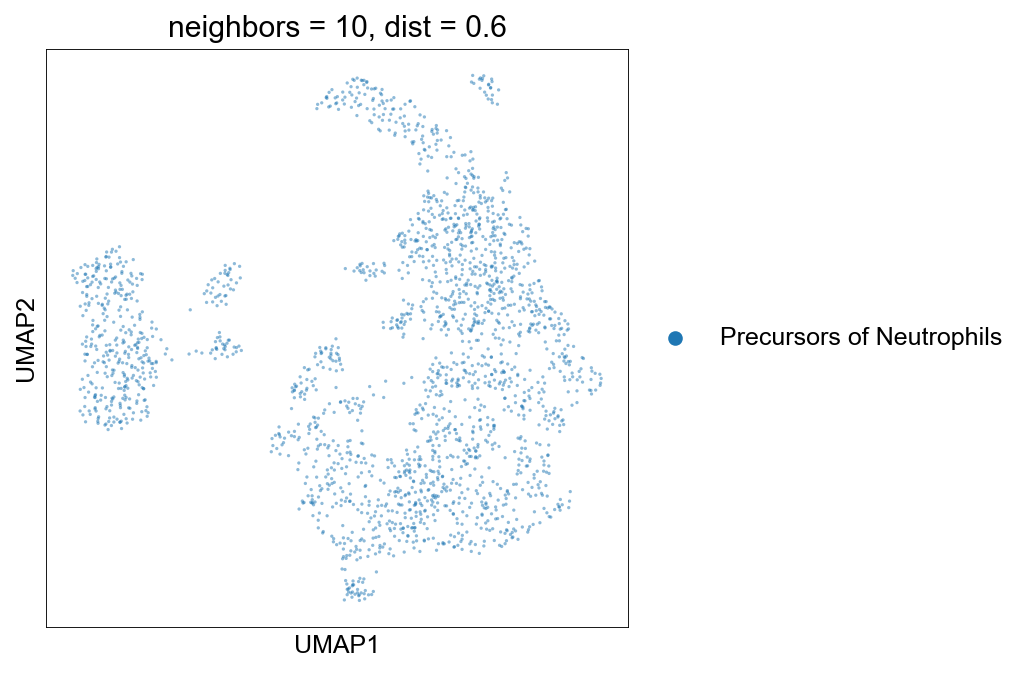

15 neighbors


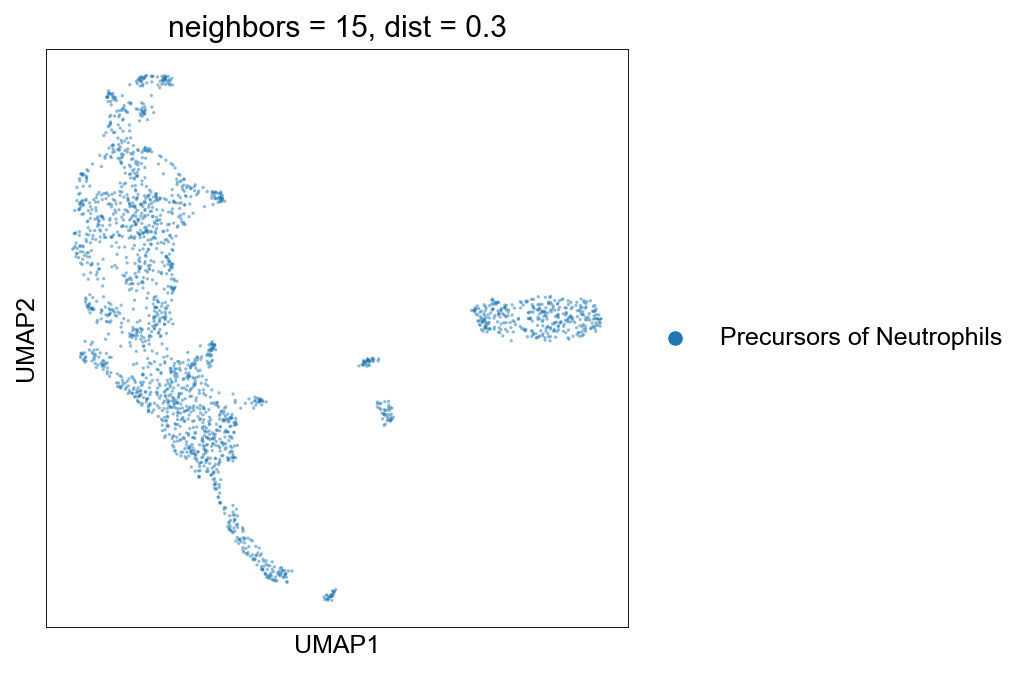

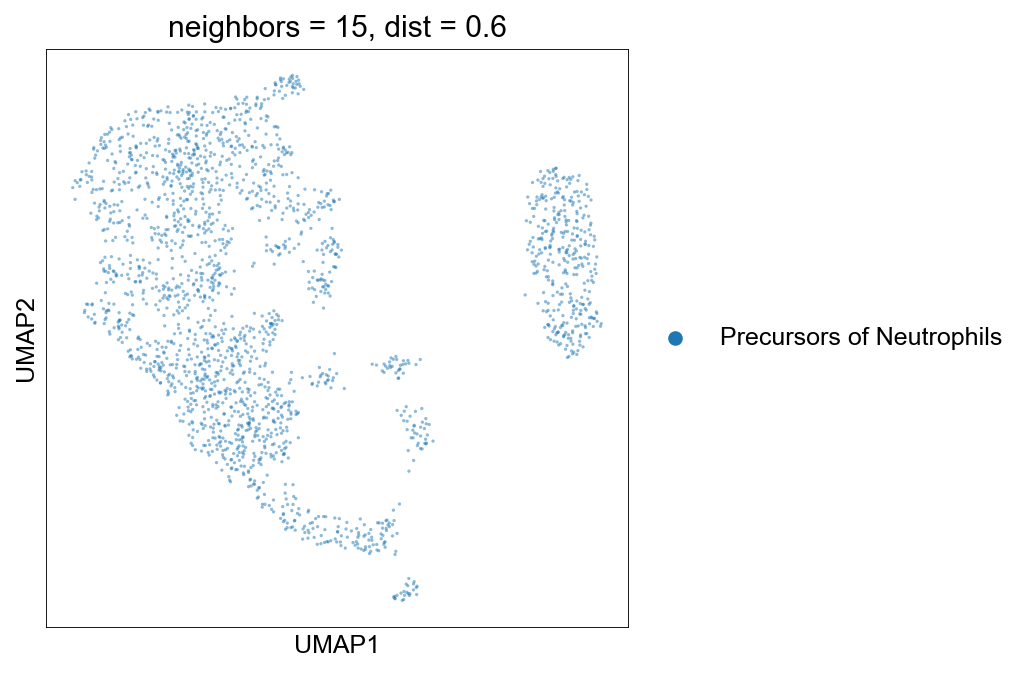

20 neighbors


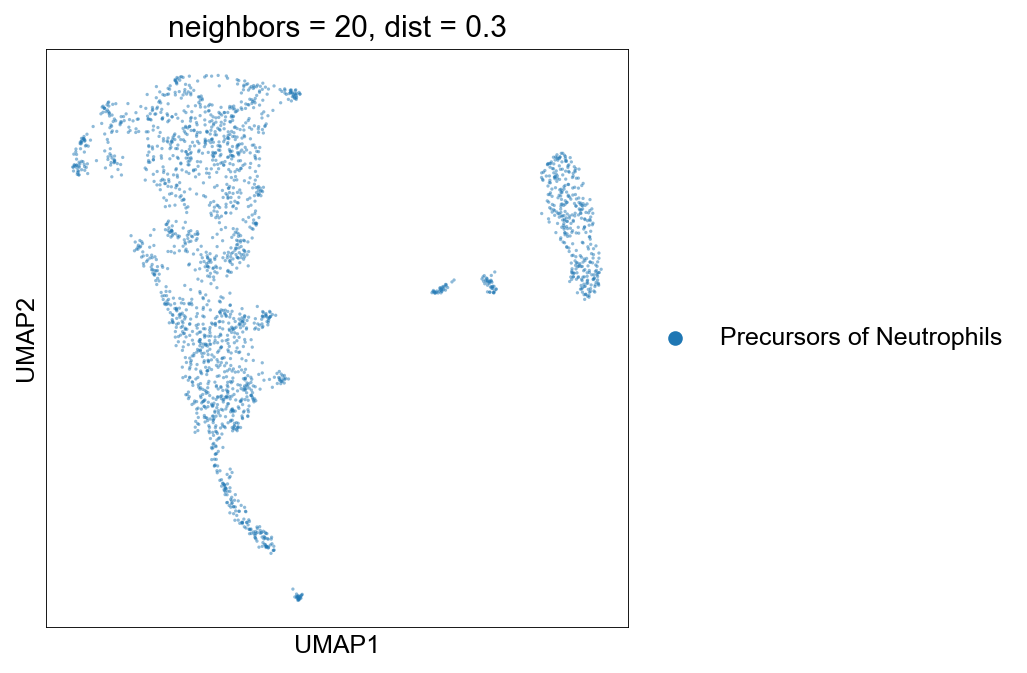

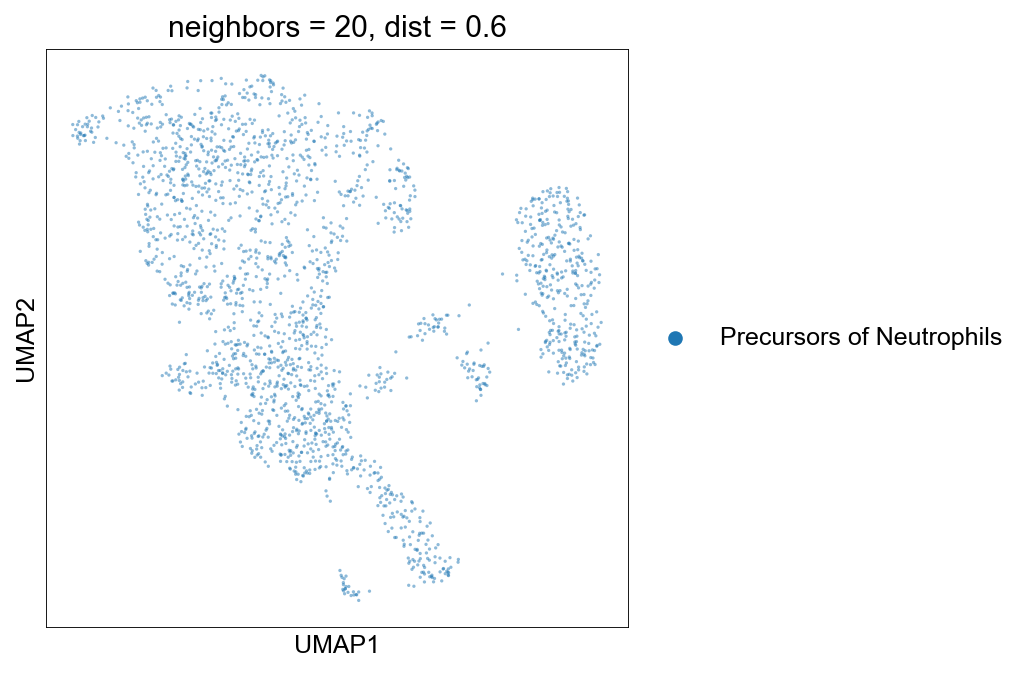

30 neighbors


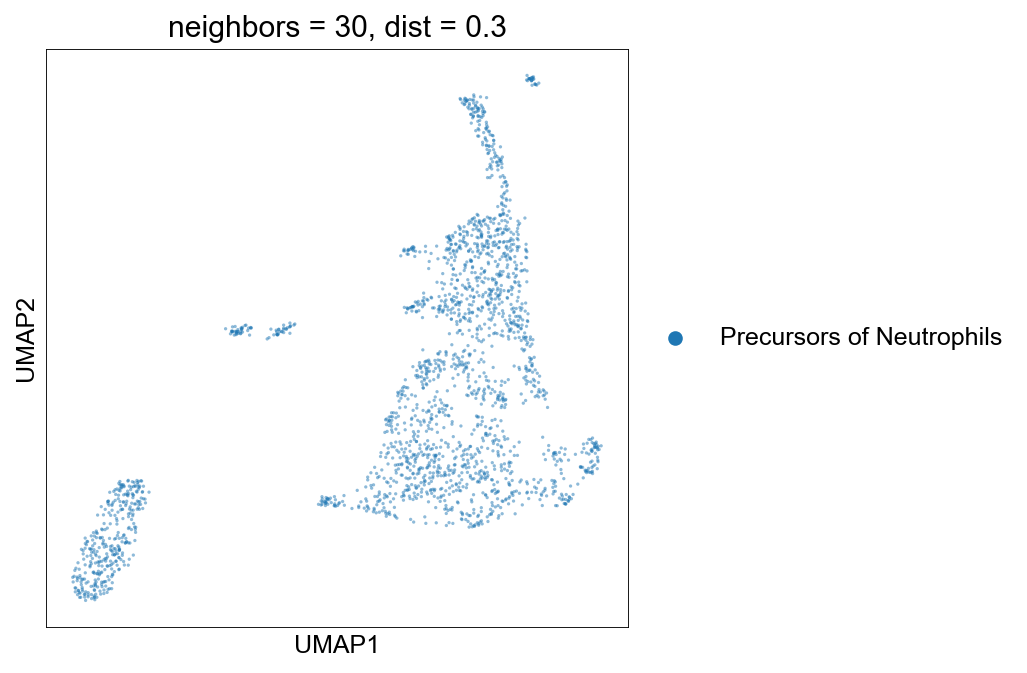

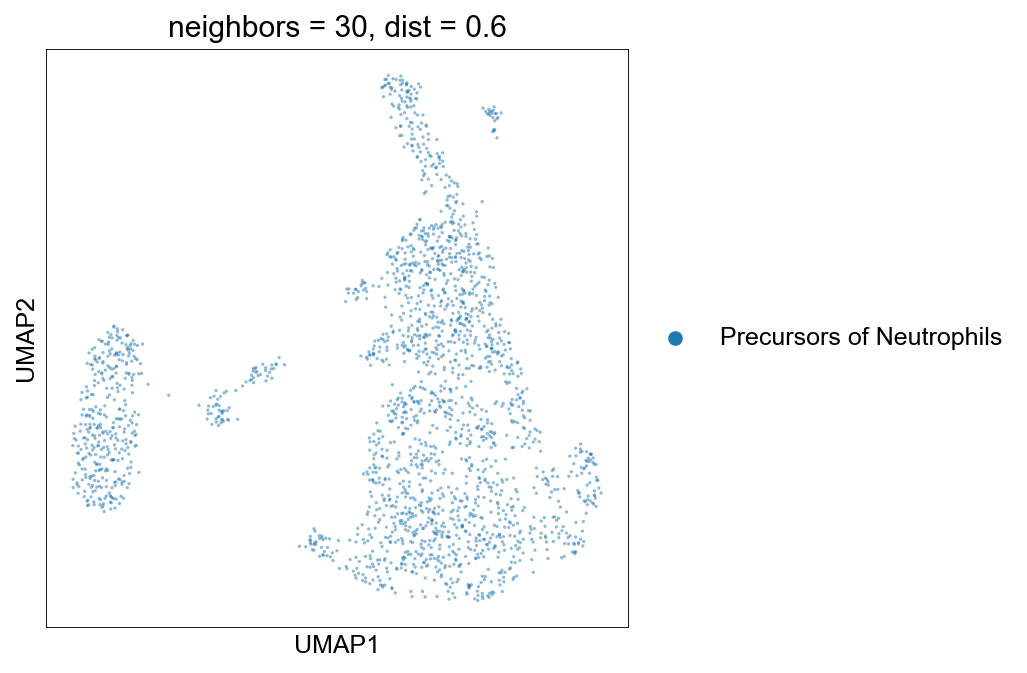

In [114]:
for j in neighbor_list:
   k = j
   print(k, 'neighbors')
   sc.pp.neighbors(cdata,k, use_rep = 'X_pca_harmony')
   for i in dist_list:
       sc.tl.umap(cdata, min_dist = i, random_state = 42)
       mpl.rcParams['figure.figsize'] = (5,5)
       sc.pl.umap(cdata, color = 'cell_type_refined', use_raw = False,
                  alpha = 0.5, s=10, title = 'neighbors = %s, dist = %s'% (j,i),
                  save ='log_z_v2000_w_batch, neighbors = %s, dist = %s_AML_prec_only.png'% (j,i))
       

## Run UMAP with the chosen parameters

In [64]:
#batch correction of the PCA coordinates using harmony (https://www.nature.com/articles/s41592-019-0619-0)
#in the experiments two versions of barcoding beads were used
#previous data exploration revealed that this is the primary source of batch effect, so correcting accordingly
sce.pp.harmony_integrate(cdata, 'code', max_iter_harmony = 20)

2025-01-23 12:07:00,747 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-23 12:07:00,969 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-23 12:07:00,976 - harmonypy - INFO - Iteration 1 of 20
2025-01-23 12:07:01,269 - harmonypy - INFO - Iteration 2 of 20
2025-01-23 12:07:01,564 - harmonypy - INFO - Iteration 3 of 20
2025-01-23 12:07:01,861 - harmonypy - INFO - Iteration 4 of 20
2025-01-23 12:07:02,156 - harmonypy - INFO - Iteration 5 of 20
2025-01-23 12:07:02,440 - harmonypy - INFO - Iteration 6 of 20
2025-01-23 12:07:02,715 - harmonypy - INFO - Iteration 7 of 20
2025-01-23 12:07:02,945 - harmonypy - INFO - Iteration 8 of 20
2025-01-23 12:07:03,211 - harmonypy - INFO - Iteration 9 of 20
2025-01-23 12:07:03,412 - harmonypy - INFO - Iteration 10 of 20
2025-01-23 12:07:03,570 - harmonypy - INFO - Iteration 11 of 20
2025-01-23 12:07:03,846 - harmonypy - INFO - Iteration 12 of 20
2025-01-23 12:07:03,984 - harmonypy - INFO - Iteration 13 of

In [65]:
sc.pp.neighbors(cdata, 20 ,use_rep='X_pca_harmony')
sc.tl.umap(cdata, min_dist = 0.6, random_state = 42)


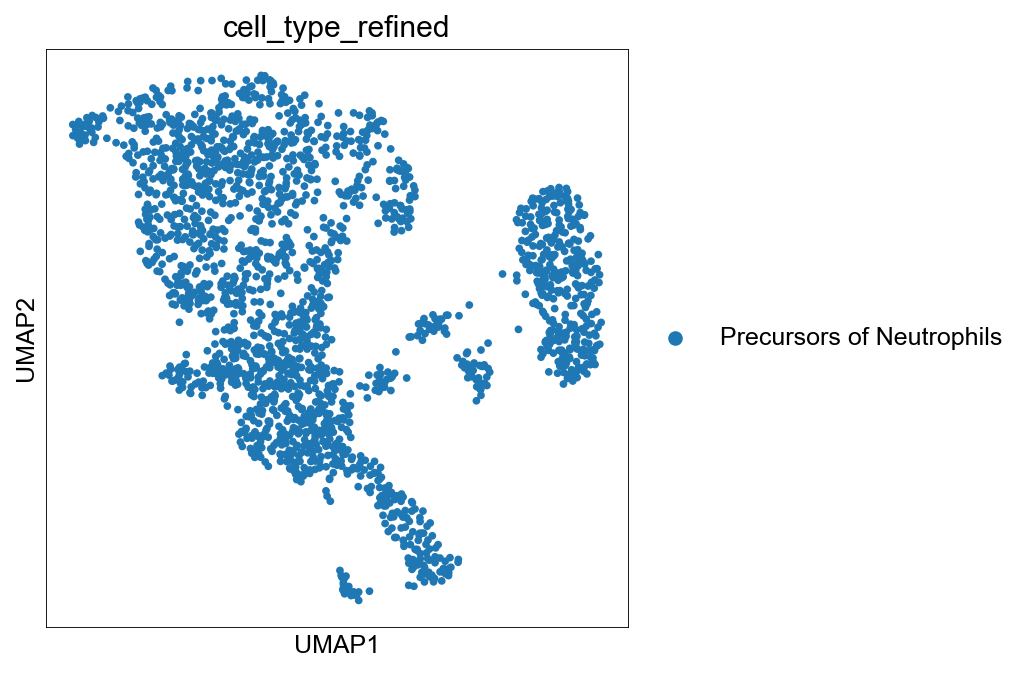

In [109]:
sc.pl.umap(cdata, color=['cell_type_refined'])

In [68]:
#record the parameters
pdict['neighbors'] = 20
pdict['min_dist'] = 0.6

In [69]:
plot_name

'AML_prec_only'

In [70]:
plot_name = 'AML_prec_only_206'
pdict['plot_name']= plot_name

## Save umap coordinates for SPRING interactive viewer

In [71]:
#save genes used

genes_used = np.array(pdict['genes_used'])
np.savetxt(project_dir+'genes_used_%s.txt'%(plot_name),genes_used, fmt='%s')

In [73]:
# continuous per-cell metadata
contvars = ['total_counts', 'pct_counts_mt', 'n_counts', 'doublet_score', 'total_counts_ribo', 'pct_counts_ribo']

# categorical
catvars = [ 'library', 'rnaseh', 'rt_condition', 'maxima', 'tso', 'gtp',
       'rt_condition_rnaseh', 'sample_code', 'sample', 'code', 
        'cell_type_old_1', 'leiden_1.4_sub', 'cell_type_old_2',
     
       'leiden_2.5_sub', 'leiden_2.5',
       'cell_type_t', 'leiden_1.0_sub_t', 'cell_type_neutrophils',
       'leiden_1.0_sub_neutrophils', 'cell_type_aml', 'leiden_1.0_sub_aml',
       'cell_type', 'cell_type_refined', 
       'subset_neut_mask', 'caps_only']
      


In [74]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    cdata.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    cdata.obs[catvar] = cdata.obs[catvar].astype('category').values

In [76]:
from scipy.sparse import csr_matrix
cdata.X = csr_matrix(cdata.X)

In [77]:
sce.exporting.spring_project(cdata, project_dir = project_dir, 
                             embedding_method = 'umap', subplot_name = plot_name, cell_groupings = catvars,
                            custom_color_tracks = contvars)

Writing subplot to /Users/justina/Documents/mokslai/LAB/amniotic_fluid/data and SPRING/AML_full/AML_prec_only_206


In [78]:
#for some reason the plot is a mirror image of X_umap coordinates, so let's make them look the same in SPRING app
embedding = cdata.obsm['X_umap']
coords = embedding - embedding.min(0)[None,:]
coords = coords * (np.array([1000, 1000]) / coords.ptp(0))[None,:] + np.array([200,-200])[None,:]
coords[:,1] = coords[:,1]*(-1)

In [79]:
#subplot path
subplot_path = project_dir + '/' + plot_name
subplot_path

'/Users/justina/Documents/mokslai/LAB/amniotic_fluid/data and SPRING/AML_full/AML_prec_only_206'

In [80]:
#saving the new coordinates to subplot folder
np.savetxt('%s/coordinates.txt'%(subplot_path),
               np.hstack((np.arange(len(embedding))[:,None], coords)),
               fmt='%i,%.6f,%.6f')

In [81]:
#check in SPRING if looks the same as X_umap plot, it does now

In [82]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)


In [83]:
#save the cdata
fname = 'AML/data/%s_%dx%d_%s.h5ad'%(plot_name, cdata.shape[0],cdata.shape[1],rz.now())
fname                                                       

'AML/data/AML_prec_only_206_2167x2000_250123_12h07.h5ad'

In [1]:
#cdata.uns.pop('spring_params')

In [85]:
cdata.write(fname)

In [86]:
#no need to save obs as only 'n_counts' appeared 

In [88]:
#okay, apparently exporting spring plot did not work correctly and did not save the cell filter
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]


In [89]:
print(len(pdict['cell_mask']), sum(pdict['cell_mask']))

86447 2167


In [90]:
np.savetxt(subplot_path + '/cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_path + '/cell_filter.npy', cell_ix)

In [91]:
#also noticed the colorbar saturation levels are not right because my adata raw is not normalized, however
#I want to keep it that way so overwriting manually

In [92]:
adata.X.sum(axis=1)

matrix([[10000.002],
        [10000.001],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.001],
        [10000.001]], dtype=float32)

In [93]:
E = adata.X.tocsc() #normalized

In [94]:
from scanpy.external.exporting import (_write_color_tracks,
                                 _get_color_stats_genes,
                                 _get_color_stats_custom,
                                 _write_color_stats
                                 )

In [95]:
gene_list = adata.var_names.values

In [96]:
continuous_extras = {}
for obs_name in contvars:
       continuous_extras[obs_name] = np.array(cdata.obs[obs_name])

In [97]:
# Create and write a dictionary of color profiles to be used by the visualizer
color_stats = {}
color_stats = _get_color_stats_genes(color_stats, E[cell_ix, :], gene_list)
color_stats = _get_color_stats_custom(color_stats, continuous_extras)
_write_color_stats(subplot_path + '/color_stats.json', color_stats)

In [98]:
fname

'AML/data/AML_prec_only_206_2167x2000_250123_12h07.h5ad'

In [100]:
plot_name


'AML_prec_only_206'